In [15]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
import re

In [17]:
p = Path("/Users/xujinliu/projects/cluster_results/behavior_predictions")

# Iterate over the csv files
df_lst = []
for file in p.glob("*.csv"):
    df = pd.read_csv(file)

    # Only take CV, pivot
    df = df[df["perf_type"] == "CV"]

    # Drop the perf_type column
    df = df.drop(columns=["perf_type"])

    # Second column is performance
    perf_col = df.columns[1]
    feature_type = "_".join(perf_col.split("_")[:-1])

    # Write this column
    perf = df[perf_col].values[0]
    df["Score"] = perf
    df["Feature"] = feature_type

    # Phase
    if "pre" in file.name:
        df["Phase"] = "pre"
    elif "post" in file.name:
        df["Phase"] = "post"
    elif "gray" in file.name:
        df["Phase"] = "gray"
    else:
        raise ValueError("Unknown phase")
    
    # Compile the regex pattern for efficiency if you're going to use it multiple times
    pattern = re.compile(r"_seed(\d+)_")

    # Find all matches and extract the indices
    matches = pattern.findall(file.name)

    # Convert matches to integers (since they are strings)
    indices = [int(match) for match in matches]
    df["Seed"] = indices[0]

    # Drop column
    df = df.drop(columns=[perf_col])
    df_lst.append(df)

# Concatenate the dataframes
df = pd.concat(df_lst)
df.head()

,subject,Score,Feature,Phase,Seed
0,10,0.531000,layer_06,gray,2
0,6,0.585000,accumulate_vis,pre,3
0,6,0.650000,layer_10,pre,2
0,7,0.464018,layer_08,pre,2
0,6,0.685000,layer_04,pre,2


<Axes: xlabel='subject', ylabel='Feature'>

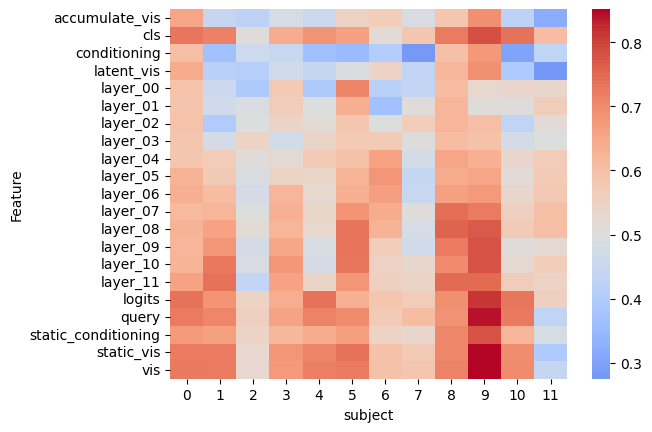

In [18]:
phase = "gray"
agg_df = df.query("Phase == @phase").groupby(["Feature", "subject"]).min(numeric_only=True).reset_index()
pivot_df = agg_df.pivot(index="Feature", columns="subject", values="Score")
sns.heatmap(pivot_df, cmap="coolwarm", center=0.5, fmt=".2f")

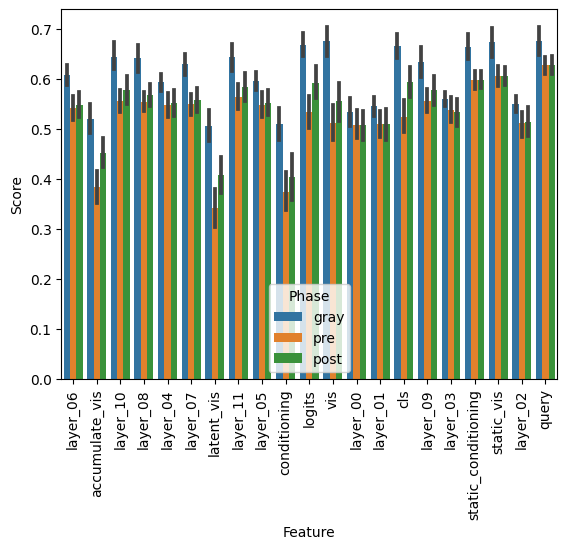

In [19]:
sns.barplot(data=df, x="Feature", y="Score", hue="Phase")

# Rotate x labels
plt.xticks(rotation=90)
None

In [90]:
layer_df = df[df["Feature"].str.contains("layer") | df["Feature"].str.contains("logits") | df["Feature"].str.contains("cls")]

# Replace logits with layer_12
layer_df["Feature"] = layer_df["Feature"].replace("logits", "layer_13")
layer_df["Feature"] = layer_df["Feature"].replace("cls", "layer_12")
layer_df["Layer"] = layer_df["Feature"].apply(lambda x: int(x.split("_")[1]))

# Lineplot takes too long to plot. Let's pre-calculate the sem for each time index and phase
grouped = layer_df.groupby(["Layer", "Phase"])['Score'].agg(['mean', 'sem', 'count'])

# Calculate the 95% CI
z = 1.96  # Z-score for 95% CI
grouped['lower_95_ci'] = grouped['mean'] - z * grouped['sem']
grouped['upper_95_ci'] = grouped['mean'] + z * grouped['sem']

grouped = grouped.reset_index()[["Layer", "Phase", "mean", "lower_95_ci", "upper_95_ci"]]
grouped.head()

/var/folders/5z/yhx8v6cn0lbcxmtb1cz5nlwc0000gn/T/ipykernel_878/1298004038.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df["Feature"] = layer_df["Feature"].replace("logits", "layer_13")
/var/folders/5z/yhx8v6cn0lbcxmtb1cz5nlwc0000gn/T/ipykernel_878/1298004038.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df["Feature"] = layer_df["Feature"].replace("cls", "layer_12")
/var/folders/5z/yhx8v6cn0lbcxmtb1cz5nlwc0000gn/T/ipykernel_878/1298004038.py:6: SettingWithCopyWarning: 
A value is try

,Layer,Phase,mean,lower_95_ci,upper_95_ci
0,0,gray,0.534085,0.506430,0.561741
1,0,post,0.507023,0.476598,0.537448
2,0,pre,0.508157,0.479390,0.536924
3,1,gray,0.544458,0.525464,0.563452
4,1,post,0.508593,0.477718,0.539468


Text(0.5, 1.0, 'Recognition prediction performance by layer')

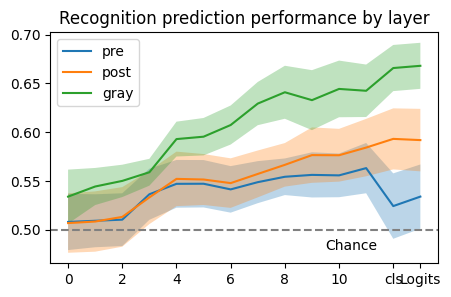

In [92]:
plt.figure(figsize=(5, 3))
for phase in ["pre", "post", "gray"]:
    sub_df = grouped.query("Phase == @phase")
    plt.plot(sub_df["Layer"], sub_df["mean"], label=phase)
    plt.fill_between(sub_df["Layer"], sub_df["lower_95_ci"], sub_df["upper_95_ci"], alpha=0.3)

# Change 12 to "logits"
plt.xticks(list(range(0, 12, 2))+[12, 13], list(range(0, 12, 2))+["cls", "Logits"])

# Plot a line for chance level
plt.axhline(0.5, color="gray", linestyle="--")
plt.annotate("Chance", (9.5, 0.48))
plt.legend()
plt.title("Recognition prediction performance by layer")

## Performance comparison with 0

In [93]:
from mne.stats import permutation_t_test
import numpy as np

In [94]:
layer_df.head()

,subject,Score,Feature,Phase,Seed,Layer
0,10,0.531000,layer_06,gray,2,6
0,6,0.650000,layer_10,pre,2,10
0,7,0.464018,layer_08,pre,2,8
0,6,0.685000,layer_04,pre,2,4
0,11,0.602500,layer_07,gray,2,7


In [95]:
# Make dataset
# [n_observations, p, phase]
perfs = []
for (subject, seed), sub_df in layer_df.groupby(["subject", "Seed"]):
    sub_df = sub_df.pivot(index="Layer", columns="Phase", values="Score")

    # Reorder phase
    sub_df = sub_df[["pre", "post", "gray"]]

    perfs.append(sub_df.values)

# Data
data = np.stack(perfs, axis=0)
original_shape = data.shape

# Flatten
data = data.reshape(original_shape[0], -1)
out = permutation_t_test(data-0.5, n_permutations=5000)[1]
out = out.reshape(original_shape[1], original_shape[2])
print(out.shape)

Permuting 4999 times...
(14, 3)


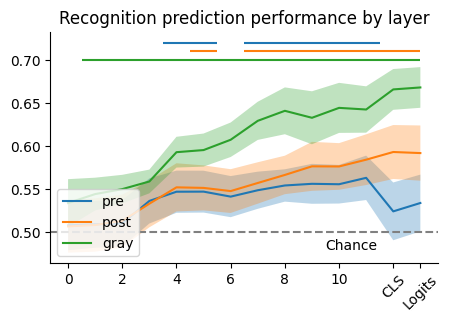

In [102]:
lines = []

# Draw the significance stripe
plt.figure(figsize=(5, 3))
for phase in ["pre", "post", "gray"]:
    sub_df = grouped.query("Phase == @phase")
    line,  = plt.plot(sub_df["Layer"], sub_df["mean"], label=phase)
    plt.fill_between(sub_df["Layer"], sub_df["lower_95_ci"], sub_df["upper_95_ci"], alpha=0.3)

    lines.append(line)

# Change 12 to "logits"
plt.xticks(list(range(0, 12, 2))+[12, 13], list(range(0, 12, 2))+["CLS", "Logits"])

# Plot a line for chance level
plt.axhline(0.5, color="gray", linestyle="--")
plt.annotate("Chance", (9.5, 0.48))
plt.legend(loc="lower left")
plt.title("Recognition prediction performance by layer")

# Remove spines
plt.gca().spines[["top", "right"]].set_visible(False)

# Getting current axes to manipulate
ax = plt.gca()

# Rotate only every other xtick label
for i, label in enumerate(ax.get_xticklabels()):
    if i >= 6:  # Selecting every other label
        label.set_rotation(45)  # Rotating the label

# Draw significance stripe
for idx in range(3):
    p_chosen = out[:, idx]
    for i, p_value in enumerate(p_chosen):
        if p_value < 0.01:
            # Adjust these values as needed
            xmin = max(i-0.5, 0)
            xmax = min(i+0.5, 13)
            plt.hlines(y=0.72-0.01*idx, xmin=xmin, xmax=xmax, color=lines[idx].get_color())

## Select gray vis

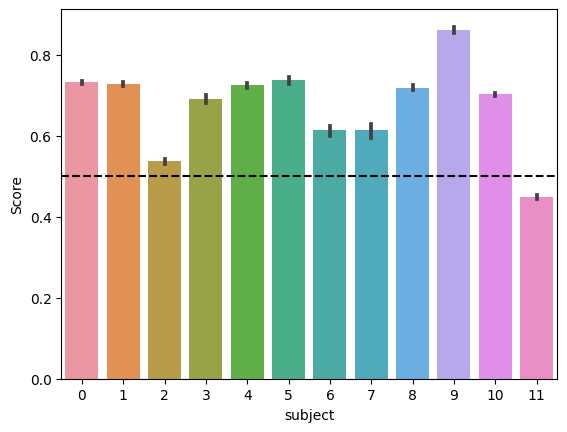

In [ ]:
selected = df.query("Phase == 'gray' & Feature == 'vis'")
sns.barplot(data=selected, x="subject", y="Score")

# Draw 0.5 line
plt.axhline(0.5, color="black", linestyle="--")

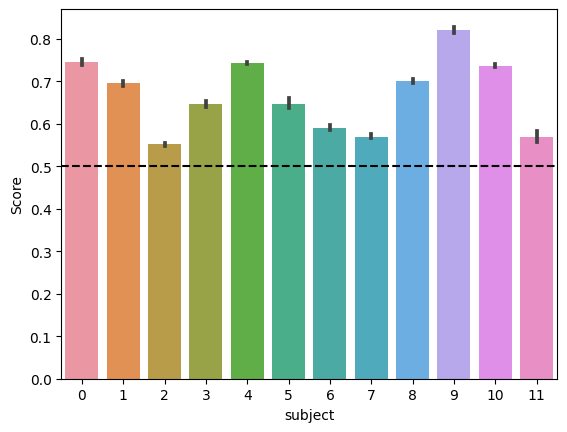

In [ ]:
selected = df.query("Phase == 'gray' & Feature == 'logits'")
sns.barplot(data=selected, x="subject", y="Score")

# Draw 0.5 line
plt.axhline(0.5, color="black", linestyle="--")